<a href="https://colab.research.google.com/github/MihaelaHudisteanu/PMP-2024/blob/main/Tema_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tema 9 - laborator 11**

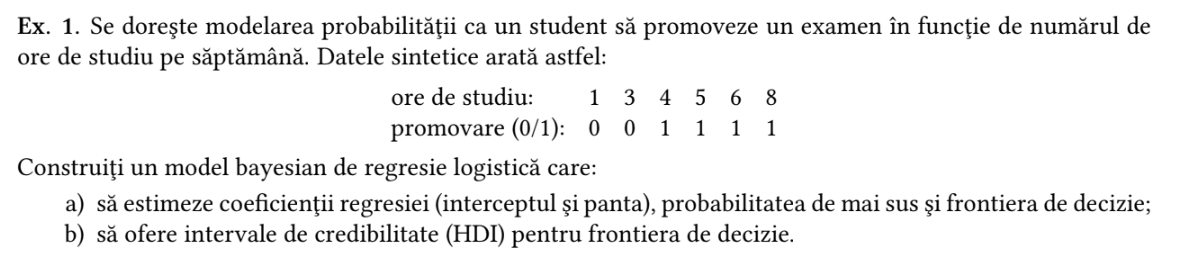

Output()

Output()

ERROR:pymc.stats.convergence:There were 313 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


([<matplotlib.axis.XTick at 0x7eb02fb834f0>,
 [Text(-2.0, 0, '0.1'),
  Text(-1.5, 0, '1.2'),
  Text(-1.0, 0, '2.3'),
  Text(-0.5, 0, '3.4'),
  Text(0.0, 0, '4.5'),
  Text(0.5, 0, '5.6'),
  Text(1.0, 0, '6.7'),
  Text(1.5, 0, '7.8'),
  Text(2.0, 0, '8.9')])

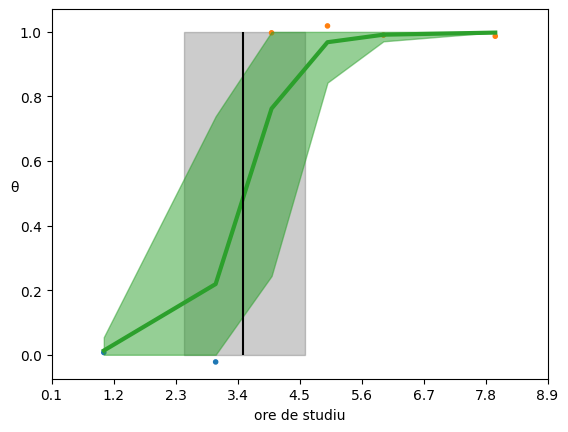

In [1]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

ore_studiu = np.array([1, 3, 4, 5, 6, 8])
promovare = np.array([0, 0, 1, 1, 1, 1])

ore_studiu_norm = (ore_studiu - ore_studiu.mean())/ore_studiu.std()

with pm.Model() as regresie_logistica:
    #zona mai prob, 10->range mai mare de valori, 1->underfit
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)

    mu = alpha + pm.math.dot(ore_studiu_norm, beta)
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    #theta = 1/2 = logistic(alpha + x*beta) <-> x=-alpha/beta
    bd = pm.Deterministic('bd', -alpha/beta)

    y = pm.Bernoulli('y', p=theta, observed=promovare)

    idata = pm.sample(1000, return_inferencedata=True, target_accept=0.95)


posterior = idata.posterior.stack(samples=('chain', 'draw'))
theta_mean = posterior['theta'].mean("samples")
idx = np.argsort(ore_studiu_norm)

plt.plot(ore_studiu_norm[idx], theta_mean[idx], color='C2', lw=3)
plt.vlines(posterior['bd'].mean(), 0, 1, color='k')

bd_hdi = az.hdi(posterior['bd'].values)
plt.fill_betweenx([0, 1], bd_hdi[0], bd_hdi[1], color='k', alpha=0.2)

plt.scatter(ore_studiu_norm, np.random.normal(promovare, 0.02), marker='.', color=[f'C{x}' for x in promovare])

az.plot_hdi(ore_studiu_norm, posterior['theta'].T, color='C2', smooth=False)

plt.xlabel('ore de studiu')
plt.ylabel('θ', rotation=0)

locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs * ore_studiu.std() + ore_studiu.mean(), 1))

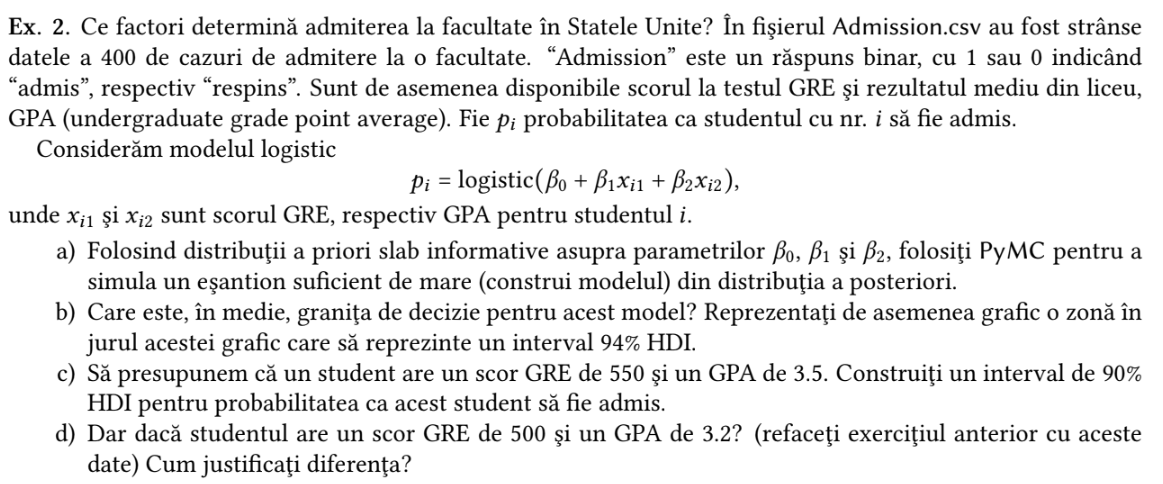

In [3]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

data = pd.read_csv('Admission.csv')

x1 = data['GRE'].values
x2 = data['GPA'].values
y_obs = data['Admission'].values

x1_normalized = (x1 - x1.mean()) / x1.std()
x2_normalized = (x2 - x2.mean()) / x2.std()


with pm.Model() as logistic_model:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=10)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=2)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=2)

    mu = beta_0 + beta_1 * x1_normalized + beta_2 * x2_normalized
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    #theta = 1/2 = logistic(beta_0 + beta_1*x1 + beta_2*x2) <-> x2 = - beta_0/beta_2 - beta_1/beta_2*x1
    bd = pm.Deterministic('bd', - beta_0/beta_2 - beta_1/beta_2 * x1_normalized)

    y = pm.Bernoulli('y', p=theta, observed=y_obs)

    idata = pm.sample(1000, return_inferencedata=True)


Output()

Output()

Text(0, 0.5, 'GPA')

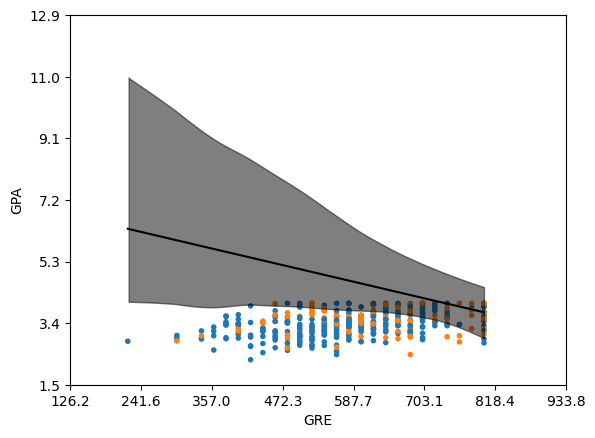

In [4]:
idx = np.argsort(x1_normalized)
bd = idata.posterior['bd'].mean(("chain", "draw"))[idx]

plt.scatter(x1_normalized, x2_normalized, marker='.', color=[f'C{x}' for x in y_obs])

plt.plot(x1_normalized[idx], bd, color='k')
#plt.xlim(-3, 3)
#plt.ylim(-4, 3)

az.plot_hdi(x1_normalized, idata.posterior['bd'], color='k', hdi_prob=0.94)

locs_x, _ = plt.xticks()
plt.xticks(locs_x, np.round(locs_x * x1.std() + x1.mean(), 1))

locs_y, _ = plt.yticks()
plt.yticks(locs_y, np.round(locs_y * x2.std() + x2.mean(), 1))

plt.xlabel('GRE')
plt.ylabel('GPA')


In [5]:
GRE_norm = (550 - x1.mean()) / x1.std()
GPA_norm = (3.5 - x2.mean()) / x2.std()

posterior_samples = idata.posterior.stack(samples=("chain", "draw"))

mu_samples = (
    posterior_samples['beta_0'] +
    posterior_samples['beta_1'] * GRE_norm +
    posterior_samples['beta_2'] * GPA_norm
)

theta_samples = 1 / (1 + np.exp(-mu_samples)).values
p_hdi = az.hdi(theta_samples, hdi_prob=0.9)

print(f"Interval HDI 90%: {p_hdi}")

Interval HDI 90%: [0.25755799 0.34737014]


In [6]:
GRE_norm = (500 - x1.mean()) / x1.std()
GPA_norm = (3.2 - x2.mean()) / x2.std()

posterior_samples = idata.posterior.stack(samples=("chain", "draw"))

mu_samples = (
    posterior_samples['beta_0'] +
    posterior_samples['beta_1'] * GRE_norm +
    posterior_samples['beta_2'] * GPA_norm
)

theta_samples = 1 / (1 + np.exp(-mu_samples)).values
p_hdi = az.hdi(theta_samples, hdi_prob=0.9)

print(f"Interval HDI 90%: {p_hdi}")

Interval HDI 90%: [0.18973801 0.28186831]
